In [ ]:
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/Shareddrives/NewAnimeGAN/female_big_faces_by_year"

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-27f9ad67-5c5e-da15-264b-c31a6d11776d)


#Loading and preprocessing

In [ ]:
image_size = 64
batch_size = 32
latent_dim = 100
channels = 3
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
normal_dataset = datasets.ImageFolder(data_path, transform=transforms.Compose([
  transforms.Resize(image_size),
  transforms.CenterCrop(image_size),
  transforms.ToTensor(),
  transforms.Normalize(*normalization_stats)
]))

In [ ]:
#run only to test things
subset = list(range(0, 10*32))
trainset = torch.utils.data.Subset(normal_dataset, subset)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                            shuffle=True, num_workers=2, pin_memory=False)

In [ ]:
dataloader = DataLoader(normal_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=2,
                        pin_memory=False)

In [ ]:
def denorm(image):
  return image * normalization_stats[1][0] + normalization_stats[0][0]

In [ ]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [ ]:
def show_batch(dataloader, nmax=64):
  for images, _ in dataloader:
    show_images(images, nmax)
    break

In [ ]:
def plot_history(d_hist, g_hist, data, save_path):
  plt.plot(d_hist, label="d1_loss")
  plt.plot(g_hist, label="g_loss")
  plt.legend()
  filename = save_path + f"/plot_hist_{str(data)}.png"
  plt.savefig(filename)
  # plt.show()
  plt.close()
  print(f"Saved {filename}")

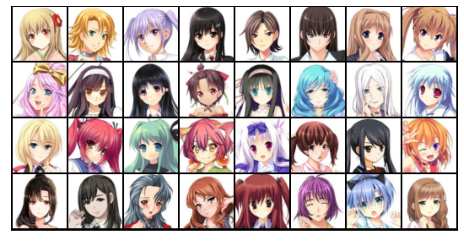

In [ ]:
show_batch(dataloader)

In [ ]:
import os
import math
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

In [ ]:
img_shape = (channels,image_size,image_size)

In [ ]:
results_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Results"
models_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models"
os.makedirs("/content/drive/Shareddrives/AnimeGAN/GAN_Results/WGAN-GP", exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

In [ ]:
cuda = True if torch.cuda.is_available() else False
cuda

True

# GAN

In [ ]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
lambda_gp = 10

In [ ]:
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(in_feat, out_feat, normalize=True):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_feat, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers
    
    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, int(np.prod(img_shape))),
        nn.Tanh()
    )

  def forward(self, z):
    img = self.model(z)
    img = img.view(img.shape[0], *img_shape)
    return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(int(np.prod(img_shape)), 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
    )
  
  def forward(self, img):
    img_flat = img.view(img.shape[0], -1)
    validity = self.model(img_flat)
    return validity

In [ ]:
#generator = Generator()
#discriminator = Discriminator()

In [ ]:
#if cuda:
#  generator.cuda()
#  discriminator.cuda()

In [ ]:
#optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
#optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
  """Calculates the gradient penalty loss for WGAN GP"""
  # Random weight term for interpolation between real and fake samples
  alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
  # Get random interpolation between real and fake samples
  interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
  d_interpolates = D(interpolates)
  fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
  # Get gradient w.r.t. interpolates
  gradients = autograd.grad(
      outputs=d_interpolates,
      inputs=interpolates,
      grad_outputs=fake,
      create_graph=True,
      retain_graph=True,
      only_inputs=True
  )[0]
  gradients = gradients.view(gradients.size(0), -1)
  graident_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return graident_penalty

In [ ]:
def train_GAN(n_epochs = 200, index = 0):
  n_critic = 5
  batches_done = 0
  d_hist, g_hist = list(), list()
  for epoch in range(n_epochs):
    i = 0
    for imgs, _ in tqdm(dataloader):

      real_imgs = Variable(imgs.type(Tensor))

      optimizer_D.zero_grad()

      z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0], latent_dim))))

      fake_imgs = generator(z)

      real_validity = discriminator(real_imgs)

      fake_validity = discriminator(fake_imgs)

      graident_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)

      d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * graident_penalty

      d_loss.backward()
      optimizer_D.step()

      optimizer_G.zero_grad()

      if i % n_critic == 0:

        fake_imgs = generator(z)

        fake_validity = discriminator(fake_imgs)
        g_loss = -torch.mean(fake_validity)

        g_loss.backward()
        optimizer_G.step()

        g_hist.append(g_loss.item())
        d_hist.append(d_loss.item())

        #  batches_done = epoch * len(dataloader) + i
      i += 1

      batches_done = epoch * len(dataloader) + i

      if batches_done % (len(dataloader)) == 0:
          save_image(fake_imgs.data[:25], f"{results_path}/{index}_{batches_done}.png", nrow=5, normalize=True)
          print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), d_loss.item(), g_loss.item())
          )
          plot_history(d_hist, g_hist, index, models_path)

# GIF Maker

In [ ]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
  # interpolate ratios between the points
  ratios = linspace(0, 1, num=n_steps)
  # linear interpolate vectors
  vectors = list()
  #vectors = torch.Tensor()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  
  return asarray(vectors)

In [ ]:
import cv2

from numpy import linspace
from numpy import asarray
from numpy.random import randn
import PIL
from PIL import Image

gif_path = "/content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/GIF_Images"
os.makedirs(gif_path, exist_ok=True)

In [ ]:
def create_gif(gifname, n_images = 1, n_frame=10):

  z = Variable(Tensor(np.random.normal(0,1,(2, latent_dim))))

  for i in range(n_images):
    latent_points = interpolate_points(z[0], z[1])

    #interpolated = torch.stack([interpolated[0], interpolated[1], interpolated[2], interpolated[3], interpolated[4], interpolated[5], interpolated[6], 
    #                        interpolated[7], interpolated[8], interpolated[9]])
    interpolated = torch.stack([latent_points[j] for j in range(n_frame)])
    gen_imgs = generator(interpolated)
    
    #print(gen_imgs.size())
    new_imgs = gen_imgs.to('cpu').detach().permute(0,2,3,1).numpy()
    img0 = new_imgs[0]
    img1 = new_imgs[1]
    img2 = new_imgs[2]
    img3 = new_imgs[3]
    img4 = new_imgs[4]
    img5 = new_imgs[5]
    img6 = new_imgs[6]
    img7 = new_imgs[7]
    img8 = new_imgs[8]
    img9 = new_imgs[9]
    #print(new_img.shape)
    
    img0 = img0 * 255.; img0 = img0.astype(np.uint8); img0 = Image.fromarray(img0)
    img1 = img1 * 255; img1 = img1.astype(np.uint8); img1 = Image.fromarray(img1)
    img2 = img2 * 255; img2 = img2.astype(np.uint8); img2 = Image.fromarray(img2)
    img3 = img3 * 255; img3 = img3.astype(np.uint8); img3 = Image.fromarray(img3)
    img4 = img4 * 255; img4 = img4.astype(np.uint8); img4 = Image.fromarray(img4)
    img5 = img5 * 255; img5 = img5.astype(np.uint8); img5 = Image.fromarray(img5)
    img6 = img6 * 255; img6 = img6.astype(np.uint8); img6 = Image.fromarray(img6)
    img7 = img7 * 255; img7 = img7.astype(np.uint8); img7 = Image.fromarray(img7)
    img8 = img8 * 255; img8 = img8.astype(np.uint8); img8 = Image.fromarray(img8)
    img9 = img9 * 255; img9 = img9.astype(np.uint8); img9 = Image.fromarray(img9)
    img0.save(gif_path + gifname, save_all=True, append_images=[img1, img2, img3, img4, img5, img6, img7, img8, img9])
    print("GIF correctly generated")

#saving and restoring


In [ ]:
def save_GAN():
  torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict()
            }, models_path + "/WGAN-GP_model.tar")

In [ ]:
save = True

generator = Generator()
discriminator = Discriminator()

if cuda:
  generator.cuda()
  discriminator.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

if (not (os.path.exists(models_path + "/WGAN-GP_model.tar"))):
  print("training of a new model")
  
  train_GAN(n_epochs=50, index=0)
  generator.eval()

else:
  print("resuming training from a loaded model")
  checkpoint = torch.load(models_path + "/WGAN-GP_model.tar")
  generator.load_state_dict(checkpoint['generator_state_dict'])
  discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

  #generator.eval()
  #discriminator.eval()

  train_GAN(n_epochs=15, index=17) #change index everytime

if(save):
   save_GAN()

resuming training from a loaded model


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 0/15] [Batch 0/1115] [D loss: -2.820762] [G loss: -1.630965]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 1/15] [Batch 0/1115] [D loss: -2.006345] [G loss: 1.524847]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 2/15] [Batch 0/1115] [D loss: -4.017237] [G loss: -2.211932]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 3/15] [Batch 0/1115] [D loss: -0.570080] [G loss: -1.694180]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8cc1d199e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8cc1d199e0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f8cc1d199e0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

[Epoch 4/15] [Batch 0/1115] [D loss: -2.932347] [G loss: -1.225116]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 5/15] [Batch 0/1115] [D loss: -3.071352] [G loss: 0.753597]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 6/15] [Batch 0/1115] [D loss: -3.684499] [G loss: -2.330577]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 7/15] [Batch 0/1115] [D loss: -2.005131] [G loss: -0.196682]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 8/15] [Batch 0/1115] [D loss: -0.148993] [G loss: -2.298161]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 9/15] [Batch 0/1115] [D loss: -3.755288] [G loss: 2.481557]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 10/15] [Batch 0/1115] [D loss: -1.749790] [G loss: 2.407269]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 11/15] [Batch 0/1115] [D loss: -1.349891] [G loss: -2.704159]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 12/15] [Batch 0/1115] [D loss: -2.012973] [G loss: -4.059303]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 13/15] [Batch 0/1115] [D loss: -2.471864] [G loss: 1.762590]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


  0%|          | 0/1115 [00:00<?, ?it/s]

[Epoch 14/15] [Batch 0/1115] [D loss: -2.606031] [G loss: 0.349123]
Saved /content/drive/Shareddrives/NewAnimeGAN/GAN_Results/WGAN-GP/Models/plot_hist_17.png


In [ ]:
create_gif("/WGAN-GP_GIF6.gif")

GIF correctly generated
